# Plot Hill Curves from HiTS
- edit data exported from HiTS
- plot all curves
- analyze curve fits to decide which ones to keep

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
pd.set_option('display.max_columns', 90)
pd.set_option('display.max_rows', 100)
import sys
sys.path.append('/mnt/c/Users/akpau/Repos/Notebooks/')
import plate_maps as pm
import importlib

%config Completer.use_jedi = False

## manually edit series count / assay date in files

In [429]:
p1 = pd.read_csv('./PARP12_inhibition_curves/PARP1_DR_Raw.csv', header=[1])
p2 = pd.read_csv('./PARP12_inhibition_curves/PARP2_DR_Raw.csv', header=[1])
p1['Target']='PARP1'
p2['Target']='PARP2'
pr = pd.concat([p1,p2])
pr=pr.reset_index(drop=True)
pr.columns=[x.replace(' ','_').replace('-','_') for x in pr.columns]
pr.Plate.nunique()

16

In [430]:
print(pr.shape)
pr=pr[~pr.intensity.isna()]
print(pr.shape)
pr.Plate.nunique()

(6144, 27)
(6054, 27)


16

In [431]:
cnx=pm.create_mysql_cnx()
for plate in pr.Plate.unique():
    df=pm.make_platemaps_from_barcode(barcode=plate, outdir=None, cnx=cnx)
    pr.loc[pr.Plate==plate, 'conc_nM']=pr[pr.Plate==plate].Well.map(dict(zip(df.IW_COORDINATES, df.Conc_nM)))
cnx.close()

In [432]:
pr['conc_um']=pr.conc_nM/1000
pr['logconc']=np.log10(pr.conc_um/1000000)

In [433]:
pr[pr.Compound==1084345].Plate.nunique()

14

In [434]:
pr['max_meas']=np.nan
pr['delta']=np.nan
pr['hitc']=np.nan

In [435]:
graphcol = 'intensity_inhibition'
for plate, compound in list(set(zip(pr[~pr.Compound.isna()].Plate, pr[~pr.Compound.isna()].Compound))):
    tmp=pr[(pr.Plate==plate) & (pr.Compound==compound)]
    assert(tmp.Target.nunique()==1)
    lowconc=tmp.conc_um.min()
    highconc=tmp.conc_um.max()
    lowmeas=tmp.loc[tmp.conc_um==lowconc, graphcol].iloc[0]
    highmeas=tmp.loc[tmp.conc_um==highconc, graphcol].iloc[0]
    lowmeas=tmp[graphcol].min()
    highmeas=tmp[graphcol].max()
    pr.loc[(pr.Plate==plate) & (pr.Compound==compound), 'max_meas']=highmeas
    pr.loc[(pr.Plate==plate) & (pr.Compound==compound), 'delta']=highmeas-lowmeas

pr['hitc']=[1 if ((x>50) & (y>50)) else 0 for (x,y) in zip(pr.max_meas, pr.delta)]
hits = pr[pr.hitc==1].Compound.unique()
len(hits)

119

In [436]:
pr[pr.max_meas.isna()].Well_Type.unique()

array(['positiveControl', 'negativeControl'], dtype=object)

In [437]:
p1 = pd.read_csv('./PARP12_inhibition_curves/PARP1_DR_Curves.csv', header=[1])
p2 = pd.read_csv('./PARP12_inhibition_curves/PARP2_DR_Curves.csv', header=[1])
p1['Target']='PARP1'
p2['Target']='PARP2'
pc = pd.concat([p1,p2])
pc=pc.reset_index(drop=True)
pc.columns=[x.replace(' ','_').replace('-','_') for x in pc.columns]
pc.shape

(932, 24)

In [438]:
pr['TC']=pr.Target+'_'+pr.Series_Count.astype(str)+"_"+pr.Compound.astype(str)
pc['TC']=pc.Target+"_"+pc.Series_Count.astype(str)+"_"+pc.Compound.astype(float).astype(str)
set(pr.TC)-set(pc.TC)

{'PARP1_1_nan', 'PARP2_1_nan'}

In [439]:
tmp=pr[['TC','max_meas','delta','hitc']].drop_duplicates()
tmp=tmp[~tmp.delta.isna()]
tmp.TC.nunique()

932

In [440]:
tmp[tmp.TC.duplicated(keep=False)] # two dose responses on same day were calculated together... just leave as is

,TC,max_meas,delta,hitc
2455,PARP1_2_1084345.0,100.351806,62.006811,1
2465,PARP1_2_1084345.0,99.950424,53.244240,1
2475,PARP1_3_1084345.0,99.806979,80.940167,1
2485,PARP1_3_1084345.0,104.864758,69.041455,1
3132,PARP2_2_1084345.0,99.444107,117.681577,1
3142,PARP2_2_1084345.0,100.767669,112.865154,1
3152,PARP2_3_1084345.0,106.471582,122.190061,1
3162,PARP2_3_1084345.0,103.302158,163.038995,1


In [441]:
print(pc.shape)
pc=pc.merge(tmp, how='left')

pc['graph']=[1 if x in hits else 0 for x in pc.Compound]
len(pc[pc.graph==1])

(932, 25)


260

In [442]:
print(pc.shape)
pc=pc.drop_duplicates()
print(pc.shape)

(936, 29)
(936, 29)


In [443]:
pc[pc.Compound.duplicated()].sort_values('Compound')

,Compound,Alias,SMILES,Lot_#,Lot_Alias,Salt,Solvate,Vendor,PAINS,Bruns_Watson_Demerit_Score,Series_Count,bottom,bottomerror,fitmethod,notes,hill,hillerror,IC50,[subst]_vs_intensity_inhibition,pIC50,R^2,top,toperror,Target,TC,max_meas,delta,hitc,graph
468,36132,NaN,Oc1ccc(Nc2nc(cs2)c3ccc(Cl)cc3)cc1,4,P7211760421,None,None,Otava,0,NaN,1,NaN,NaN,Logistic_FourParameters,Fit FAILED,NaN,NaN,> 39.8,"[x:39.8, y:13.4714724028758], [x:2.488, y:-22....",NaN,NaN,NaN,NaN,PARP2,PARP2_1_36132.0,22.008806,44.808629,0,0
469,36776,NaN,COc1ccc(cc1)C2C(=C(N)Oc3[nH]nc(C)c23)C#N,3,P1590324,None,None,Otava,0,75,1,NaN,NaN,Logistic_FourParameters,Fit FAILED,NaN,NaN,> 39.8,"[x:39.8, y:-91.6784832433049], [x:2.488, y:-12...",NaN,NaN,NaN,NaN,PARP2,PARP2_1_36776.0,-51.248551,76.416793,0,0
470,38271,NaN,Nc1c(C#N)c2nc3ccccc3nc2n1c4ccc(O)cc4,4,P0124040211,None,None,Otava,0,NaN,1,NaN,NaN,Logistic_FourParameters,Fit FAILED,NaN,NaN,> 39.8,"[x:39.8, y:-28.1376029085929], [x:2.488, y:-10...",NaN,NaN,NaN,NaN,PARP2,PARP2_1_38271.0,45.988697,127.034596,0,0
471,50085,NaN,CN1C(=O)NC(=O)c2c1nc(N3CCCCCC3)n2C,2,P1162085,None,None,Otava,0,NaN,1,NaN,NaN,Logistic_FourParameters,Fit FAILED,NaN,NaN,> 39.8,"[x:39.8, y:-32.8341802692178], [x:2.488, y:-74...",NaN,NaN,NaN,NaN,PARP2,PARP2_1_50085.0,-16.293087,92.437970,0,0
472,51009,NaN,Oc1nc(NCc2ccccc2)nc3sc4CCCCc4c13,2,P6057716,None,None,Otava,0,NaN,1,NaN,NaN,Logistic_FourParameters,Fit FAILED,NaN,NaN,> 39.8,"[x:39.8, y:-20.9248831445934], [x:2.488, y:-16...",NaN,NaN,NaN,NaN,PARP2,PARP2_1_51009.0,19.838217,89.803995,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464,1084345,NaN,CCc1cc2ncc(CN3CCN(CC3)c4ccc(nc4)C(=O)NC)cc2nc1O,2,AZD5305,None,None,NaN,0,16,3,-20.0,NaN,Logistic_FourParameters,Fit succeeded; bottom fixed at -20,1.1570,0.1305,0.001336,"[x:2.488, y:99.8069793513453], [x:2.488, y:101...",8.874,0.9974,98.00,1.4090,PARP1,PARP1_3_1084345.0,99.806979,80.940167,1,1
465,1084345,NaN,CCc1cc2ncc(CN3CCN(CC3)c4ccc(nc4)C(=O)NC)cc2nc1O,2,AZD5305,None,None,NaN,0,16,3,-20.0,NaN,Logistic_FourParameters,Fit succeeded; bottom fixed at -20,1.1570,0.1305,0.001336,"[x:2.488, y:99.8069793513453], [x:2.488, y:101...",8.874,0.9974,98.00,1.4090,PARP1,PARP1_3_1084345.0,104.864758,69.041455,1,1
466,1084345,NaN,CCc1cc2ncc(CN3CCN(CC3)c4ccc(nc4)C(=O)NC)cc2nc1O,2,AZD5305,None,None,NaN,0,16,4,-20.0,NaN,Logistic_FourParameters,Fit succeeded; bottom fixed at -20,6.0230,6.1510,0.002562,"[x:2.488, y:100.239893976506], [x:19.9, y:99.5...",8.591,0.9993,98.76,0.9898,PARP1,PARP1_4_1084345.0,100.318653,120.847294,1,1
934,1084345,NaN,CCc1cc2ncc(CN3CCN(CC3)c4ccc(nc4)C(=O)NC)cc2nc1O,2,AZD5305,None,None,NaN,0,16,4,-20.0,NaN,Logistic_FourParameters,Fit succeeded; bottom fixed at -20,0.8711,0.1698,0.04251,"[x:2.488, y:97.9576563633963], [x:19.9, y:100....",7.372,0.9885,100.70,5.7930,PARP2,PARP2_4_1084345.0,100.314287,126.225883,1,1


In [444]:
len(pc[pc.hitc==1])

169

In [446]:
pc.Compound.nunique()

457

In [450]:
pr.to_csv('./PARP12_inhibition_curves/PARP12_DR_Raw_with_conc.csv')

In [451]:
pc['relation']=np.nan

In [452]:
pc.columns

Index(['Compound', 'Alias', 'SMILES', 'Lot_#', 'Lot_Alias', 'Salt', 'Solvate',
       'Vendor', 'PAINS', 'Bruns_Watson_Demerit_Score', 'Series_Count',
       'bottom', 'bottomerror', 'fitmethod', 'notes', 'hill', 'hillerror',
       'IC50', '[subst]_vs_intensity_inhibition', 'pIC50', 'R^2', 'top',
       'toperror', 'Target', 'TC', 'max_meas', 'delta', 'hitc', 'graph',
       'relation'],
      dtype='object')

In [453]:
# pc[pc.Series_Count>1]

In [454]:
# cols = ['bottom', 'bottomerror', 'fitmethod', 'notes', 'hill', 'hillerror',
#        'IC50', 'pIC50', 'R^2', 'top',
#        'toperror', ]

# rows=[]
# for i, row in pc.iterrows():
#     for col in cols:
#         try: 
#             row[col]=row[col].split(',')
#             if col=='bottom':
#                 listlen = len(row[col])
#             if len(row[col])==1:
#                 # print(col)
#                 row[col]=row[col] * listlen
#         except: pass
#     rows.append(pd.DataFrame(row).T)
# pc=pd.concat(rows)
# pc=pc.explode(cols)

In [455]:
pc[pc.IC50.astype(str).str.contains(',')]

,Compound,Alias,SMILES,Lot_#,Lot_Alias,Salt,Solvate,Vendor,PAINS,Bruns_Watson_Demerit_Score,Series_Count,bottom,bottomerror,fitmethod,notes,hill,hillerror,IC50,[subst]_vs_intensity_inhibition,pIC50,R^2,top,toperror,Target,TC,max_meas,delta,hitc,graph,relation


In [611]:
pc.loc[pc.IC50.astype(str).str.contains('>'), 'relation']='>'
pc.loc[pc.IC50.astype(str).str.contains('>'), 'IC50']=39.8
pc.IC50=pc.IC50.astype(float)
pc.loc[pc.IC50==39.8, 'pIC50']=-np.log10(39.8/1000000)-1
pc['solubility']=[0 if x in solissues else 1 for x in pc.Compound]

In [639]:
pc.solubility.value_counts()

1    874
0     62
Name: solubility, dtype: int64

#### Prism:

#### `Y = Bottom + (Top - Bottom) / (1 + 10^((LogIC50 - X) * HillSlope))`
#### `Y = Bottom + (Top - Bottom) / (1 + (IC50 / X) ^ HillSlope)`

In [640]:
def plot_parp_curves(compound, raw, curve, save_fig=False, save_lab='HiTS'):
    sns.set_context('poster')
    graphcol=f'intensity_inhibition'
    fig, ax = plt.subplots(1,4,figsize=(24,10),sharey=True,gridspec_kw={'width_ratios': [5,1,5,1]})
    for i, targ in [(0,'PARP1'),(2,'PARP2')]:
        ppc=curve[(curve.Compound==compound) & (curve.Target==targ)].copy()
        if len(ppc)>1:
            note=list(set(ppc.notes.tolist()))[0]
            ppc.IC50=ppc.IC50.astype(float)
            note=set(ppc.notes.tolist())
            ppc=ppc.groupby('Compound').mean()
            ppc['notes']=str(note)
        ppr=raw[(raw.Compound==compound) & (raw.Target==targ)].copy()

        logconcmin=ppr.logconc.min()-0.5
        logconcmax=ppr.logconc.max()+0.5
        pctmin = ppr[graphcol].min()
        pctmax = ppr[graphcol].max()
        if ((ppr.hitc.iloc[0]==1) & ('succeeded' in ppc.notes.iloc[0])):
            # save_fig=True
            try:
                x = np.linspace(logconcmin, logconcmax, 1000)
                y = ppc.bottom.iloc[0] + ((ppc.top.iloc[0] - ppc.bottom.iloc[0])/(1+10**((-ppc.pIC50.iloc[0] - x)*float(ppc.hill.iloc[0]))))
                # y = row.bottom + (row.top-row.bottom)/(1+(float(row.IC50)/x)**float(row.hill))
                ax[i].plot(x,y,c='cornflowerblue')
            except:
                pass
        ax[i].scatter(x=ppr.logconc.values, y=ppr[graphcol].values, s=50)
        ax[i].set_title(f"{int(compound)} {targ} IC50={ppc.IC50.iloc[0]} uM\nHITC: {int(ppr.hitc.iloc[0])}; {ppc.notes.iloc[0]}\nSoluble: {ppc['solubility'].iloc[0]}; R^2={ppc['R^2'].iloc[0]}")
        ax[i].set_xlabel('log(Concentration in uM)')
        ax[i].set_xlim(logconcmin, logconcmax)
        ax[i].set_ylim(-105, 105)
        ax[i].hlines(50, xmin=logconcmin, xmax=logconcmax, color='orange', zorder=0)
        plateNegCtrl=pr[(raw.Plate==ppr.Plate.iloc[0])&(raw.Well_Type=='negativeControl')]
        ax[i+1].hist(plateNegCtrl[graphcol], orientation='horizontal', range=(-105,105), bins=22)    
        ax[i+1].set_xlabel('negCtrlDist')
    ax[0].set_ylabel(graphcol)
    fig.patch.set_facecolor('white')
    fig.tight_layout()
    if save_fig:
        plt.savefig(f'./curve_images/{compound}_{save_lab}_curvefit.png')
        plt.close()

In [641]:
plotdf=pc[(pc.graph==1)]
len(plotdf)

260

In [642]:
sns.set_context('poster')
graphcol=f'intensity_inhibition'

for cmpd in plotdf.Compound.unique().tolist():
    plot_parp_curves(cmpd, pr, pc, save_fig=True)

In [621]:
from scipy.optimize import curve_fit 
import warnings
##########################################################
# graphics output section
def ModelAndScatterPlot(graphWidth, graphHeight):
    f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
    axes = f.add_subplot(111)

    # first the raw data as a scatter plot
    axes.plot(xData, yData,  'D')

    # create data for the fitted equation plot
    xModel = np.linspace(min(xData), max(xData))
    yModel = func(xModel, *fittedParameters)

    # now the model as a line plot
    axes.plot(xModel, yModel)

    axes.set_xlabel('X Data') # X axis data label
    axes.set_ylabel('Y Data') # Y axis data label
    axes.set_ylim(-105,105)
    plt.show()
    plt.close('all') # clean up after using pyplot

In [622]:
def func(x, Bottom, Top, LogIC50, HillSlope): 
    return (Bottom + (Top-Bottom)/(1+10**((LogIC50-x)*HillSlope)))

In [623]:
plt.close('all')

In [624]:
allparams = {}

for cmpd in plotdf.Compound.unique().tolist():
    for i, targ in enumerate(['PARP1','PARP2']):
        ppr=pr[(pr.Compound==cmpd) & (pr.Target==targ)].copy()
        plateNegCtrl=pr[(pr.Plate==ppr.Plate.iloc[0])&(pr.Well_Type=='negativeControl')][graphcol].mean()
        logconc=ppr.logconc
        scaling_factor = ppr[graphcol].values

        # rename data for simpler code re-use later
        xData = logconc
        yData = scaling_factor
    
        # these are the same as the scipy defaults
        # initialParameters = np.array([init[top], init[bottom], np.log10(float(init[ic50])/1000000), init[hill]])
        initialParameters = np.array([100, -20, -5.5, 1])

        # do not print unnecessary warnings during curve_fit()
        warnings.filterwarnings("ignore")

        try:
            # curve fit the test data
            fittedParameters, pcov = curve_fit(func, xData, yData, initialParameters)

            modelPredictions = func(xData, *fittedParameters) 

            absError = modelPredictions - yData

            SE = np.square(absError) # squared errors
            MSE = np.mean(SE) # mean squared errors
            RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
            Rsquared = 1.0 - (np.var(absError) / np.var(yData))
            IC50 = 10**fittedParameters[2]*1000000

            fittedParameters=list(fittedParameters)
            fittedParameters.extend([RMSE, Rsquared, IC50])
            allparams[targ+"_"+str(cmpd)]=fittedParameters

        except:
            # print(f'{targ} {cmpd} fit failed')
            allparams[targ+"_"+str(cmpd)]=[np.nan]*7

In [625]:
df=pd.DataFrame.from_dict(allparams).T
df.columns=['bottom','top','LogIC50','hill','RMSE','R^2','IC50']
df.columns=['SciPy_'+col for col in df.columns]
df=df.reset_index()
df=df.rename(columns={'index':'Compound'})
df[['Target','Compound']]=df.Compound.str.split('_', expand=True)
df.Compound=df.Compound.astype(int)

In [626]:
pc=pc.merge(df, how='left')

In [627]:
pc.columns

Index(['Compound', 'Alias', 'SMILES', 'Lot_#', 'Lot_Alias', 'Salt', 'Solvate',
       'Vendor', 'PAINS', 'Bruns_Watson_Demerit_Score', 'Series_Count',
       'bottom', 'bottomerror', 'fitmethod', 'notes', 'hill', 'hillerror',
       'IC50', '[subst]_vs_intensity_inhibition', 'pIC50', 'R^2', 'top',
       'toperror', 'Target', 'TC', 'max_meas', 'delta', 'hitc', 'graph',
       'relation', 'SciPy_bottom', 'SciPy_top', 'SciPy_LogIC50', 'SciPy_hill',
       'SciPy_RMSE', 'SciPy_R^2', 'SciPy_IC50', 'SciPy_pIC50', 'SciPy_hitc',
       'SciPy_graph', 'solubility'],
      dtype='object')

<AxesSubplot:xlabel='bottom', ylabel='SciPy_bottom'>

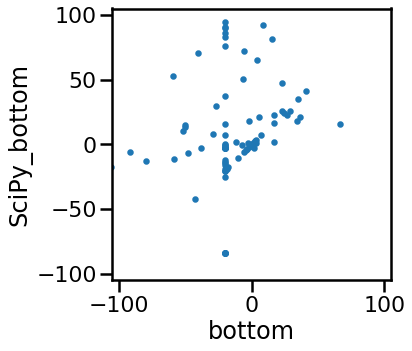

In [628]:
pc.plot(x=f'bottom', y=f'SciPy_bottom', kind='scatter', figsize=(5,5), xlim=(-105,105), ylim=(-105,105))

<AxesSubplot:xlabel='top', ylabel='SciPy_top'>

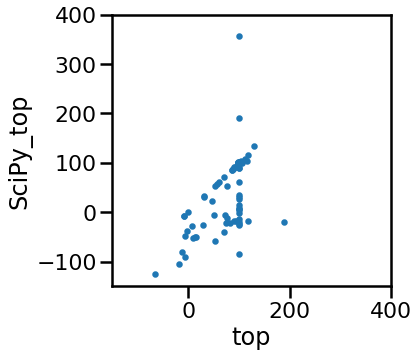

In [629]:
pc.plot(x=f'top', y=f'SciPy_top', kind='scatter', figsize=(5,5), xlim=(-150,400), ylim=(-150,400))

<AxesSubplot:xlabel='IC50', ylabel='SciPy_IC50'>

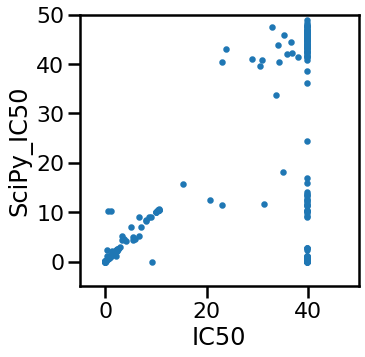

In [630]:
pc.plot(x=f'IC50', y=f'SciPy_IC50', kind='scatter', figsize=(5,5), xlim=(-5,50), ylim=(-5,50))

<AxesSubplot:xlabel='pIC50', ylabel='SciPy_pIC50'>

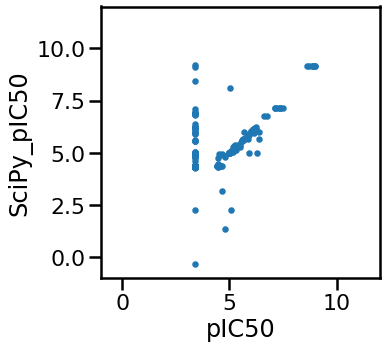

In [631]:
pc['SciPy_pIC50']=-pc.SciPy_LogIC50
pc.plot(x=f'pIC50', y=f'SciPy_pIC50', kind='scatter', figsize=(5,5), xlim=(-1,12), ylim=(-1,12))

In [632]:
pc['SciPy_hitc']=~pc.SciPy_hill.isna().astype(int)+2
hits=pc[pc.SciPy_hitc==1].Compound.unique()
pc['SciPy_graph']=[1 if x in hits else 0 for x in pc.Compound]

In [643]:
plotdf=pc[pc.SciPy_graph==1]

plotdf=plotdf[['Compound', 'Alias', 'SMILES', 'Lot_#', 'Lot_Alias', 'Salt', 'Solvate',
       'Vendor', 'PAINS', 'Bruns_Watson_Demerit_Score', 'Series_Count',
        'Target', 'TC', 'max_meas', 'delta', 'hitc', 'relation', 'SciPy_bottom', 'SciPy_top', 'SciPy_hill', 'SciPy_R^2', 'SciPy_IC50', 'SciPy_pIC50', 'SciPy_hitc', 'SciPy_graph','solubility']]
plotdf.columns=['Compound', 'Alias', 'SMILES', 'Lot_#', 'Lot_Alias', 'Salt', 'Solvate',
       'Vendor', 'PAINS', 'Bruns_Watson_Demerit_Score', 'Series_Count',
        'Target', 'TC', 'max_meas', 'delta', 'hitc', 'relation', 'bottom', 'top', 'hill','R^2', 'IC50', 'pIC50', 'SciPy_hitc', 'graph','solubility']
plotdf['notes']='SciPy fit succeeded'

In [644]:
sns.set_context('poster')
graphcol=f'intensity_inhibition'

for cmpd in plotdf.Compound.unique().tolist():
    plot_parp_curves(compound=cmpd, curve=plotdf, raw=pr, save_fig=True, save_lab='SciPy')

<AxesSubplot:>

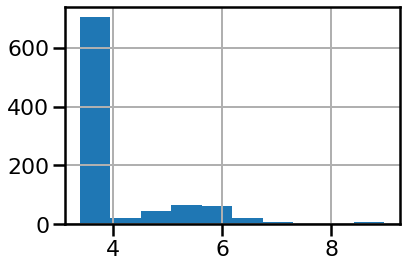

In [635]:
pc.pIC50.hist()

<AxesSubplot:>

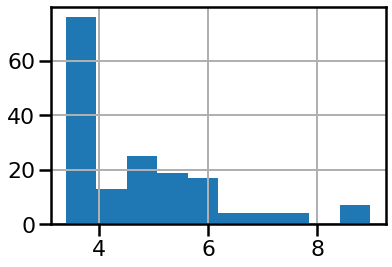

In [636]:
pc[pc.hitc==1].pIC50.hist()

In [637]:
pc[pc.hitc==1].pIC50.mean()

4.640543707233134

In [638]:
pc.pIC50.mean()

3.9523806808334654

In [478]:
drop_from_hits = [180478,1018548,1084027,1084049,1084130, 1084198, 1084211,
                  1084266,1084269,1084274,1084304,1084294,1084324,1084326,1084330]
keep_extra_from_scipy = [
    64122,
    92841,
    154843,
    180370,
    181763,
    193959,
    
    815117,
    830781,
    849198,
    871086,
    874864,
    897986,
    992295,
    
    1018548,
    1059267,
    1067000,
    1083999,
    1084001,
    1084002,
    1084006,
    1084015,
    1084016,
    1084019,
    
    1084027,
    1084028,
    1084030,
    1084035,
    
    1084100,
    1084104,
    1084105,
    1084106,
    1084107,

    1084111,
    1084127,
    1084128,
    1084130,
    1084131,
    1084132,
    1084133,
    1084135,
    
    1084170,
    1084180,
    1084193,
    1084195,
    1084196,
    1084200,
    1084211,
    1084219,
    
    1084244,
    1084248,
    1084266,
    1084267,
    1084269,
    1084270,
    1084271,
    
    1084274,
    1084275,
    1084276,
    1084278,
    1084279,
    1084280,
    
    1084289,
    
    
]

In [553]:
pc.columns

Index(['Compound', 'Alias', 'SMILES', 'Lot_#', 'Lot_Alias', 'Salt', 'Solvate',
       'Vendor', 'PAINS', 'Bruns_Watson_Demerit_Score', 'Series_Count',
       'bottom', 'bottomerror', 'fitmethod', 'notes', 'hill', 'hillerror',
       'IC50', '[subst]_vs_intensity_inhibition', 'pIC50', 'R^2', 'top',
       'toperror', 'Target', 'TC', 'max_meas', 'delta', 'hitc', 'graph',
       'relation', 'SciPy_bottom', 'SciPy_top', 'SciPy_LogIC50', 'SciPy_hill',
       'SciPy_RMSE', 'SciPy_R^2', 'SciPy_IC50', 'SciPy_pIC50', 'SciPy_hitc',
       'SciPy_graph'],
      dtype='object')

In [554]:
pch=pc[pc.hitc==1].copy(deep=True) # keep all valid hits
print(pch.shape)
pch=pch[~pch.Compound.isin(keep_extra_from_scipy)] # except where we want the scipy fits instead
print(pch.shape)
pch=pch[~pch.Compound.isin(drop_from_hits)] # except the ones that should be dropped b/c bad fits
print(pch.shape)

(169, 40)
(97, 40)
(91, 40)


In [555]:
pcs=pc[pc.Compound.isin(keep_extra_from_scipy)].copy(deep=True)
pcs.shape

(124, 40)

In [556]:
pch=pch[['Compound', 'Alias', 'SMILES', 'Lot_#', 'Lot_Alias', 'Salt', 'Solvate',
       'Vendor', 'PAINS', 'Bruns_Watson_Demerit_Score', 'bottom',
       'bottomerror', 'fitmethod', 'notes', 'hill', 'hillerror', 'IC50', 'pIC50', 'R^2', 'top', 'toperror',
       'Target', 'max_meas','delta', 'hitc']]
pcs.columns

Index(['Compound', 'Alias', 'SMILES', 'Lot_#', 'Lot_Alias', 'Salt', 'Solvate',
       'Vendor', 'PAINS', 'Bruns_Watson_Demerit_Score', 'Series_Count',
       'bottom', 'bottomerror', 'fitmethod', 'notes', 'hill', 'hillerror',
       'IC50', '[subst]_vs_intensity_inhibition', 'pIC50', 'R^2', 'top',
       'toperror', 'Target', 'TC', 'max_meas', 'delta', 'hitc', 'graph',
       'relation', 'SciPy_bottom', 'SciPy_top', 'SciPy_LogIC50', 'SciPy_hill',
       'SciPy_RMSE', 'SciPy_R^2', 'SciPy_IC50', 'SciPy_pIC50', 'SciPy_hitc',
       'SciPy_graph'],
      dtype='object')

In [557]:
pcs=pcs[['Compound', 'Alias', 'SMILES', 'Lot_#', 'Lot_Alias', 'Salt', 'Solvate',
       'Vendor', 'PAINS', 'Bruns_Watson_Demerit_Score',
       'Target', 'SciPy_bottom', 'SciPy_top',
       'SciPy_LogIC50', 'SciPy_hill', 'SciPy_RMSE', 'SciPy_R^2', 'SciPy_IC50',
       'max_meas','delta', 'hitc']]

In [558]:
pcs.columns=['Compound', 'Alias', 'SMILES', 'Lot_#', 'Lot_Alias', 'Salt', 'Solvate',
       'Vendor', 'PAINS', 'Bruns_Watson_Demerit_Score', 'Target',
       'bottom', 'top', 'LogIC50', 'hill',
       'RMSE', 'R^2', 'IC50', 'max_meas','delta', 'hitc']

In [559]:
set(pch.columns) - set(pcs.columns)

{'bottomerror', 'fitmethod', 'hillerror', 'notes', 'pIC50', 'toperror'}

In [560]:
pch.fitmethod.unique()

array(['Logistic_FourParameters'], dtype=object)

In [561]:
pcs['notes']='Fit succeeded with SciPy'
pcs['fitmethod']='Logistic_FourParameters'
pcs['pIC50']=-pcs['LogIC50']

In [562]:
set(pcs.columns)-set(pch.columns)

{'LogIC50', 'RMSE'}

In [563]:
pcs=pcs.drop(columns='LogIC50')

In [564]:
pos=pd.concat([pch,pcs])

In [565]:
pp1=pos[pos.Target=='PARP1'].copy(deep=True)
pp2=pos[pos.Target=='PARP2'].copy(deep=True)

In [566]:
poscmpds = pp1.Compound.unique().tolist()
neg=pc[(~pc.Compound.isin(poscmpds))&(pc.Target=='PARP1')].copy(deep=True)
neg=neg[['Compound', 'Alias', 'SMILES', 'Lot_#', 'Lot_Alias', 'Salt', 'Solvate',
       'Vendor', 'PAINS', 'Bruns_Watson_Demerit_Score', 'bottom',
       'bottomerror', 'fitmethod', 'notes', 'hill', 'hillerror', 'IC50', 'pIC50', 'R^2', 'top', 'toperror',
       'Target', 'max_meas','delta', 'hitc']]
len(poscmpds)+neg.Compound.nunique()

457

In [567]:
ap1=pd.concat([pp1,neg])
ap1=ap1.reset_index(drop=True)
ap1.Compound.nunique(), ap1.shape

(457, (467, 26))

In [568]:
poscmpds = pp2.Compound.unique().tolist()
neg=pc[(~pc.Compound.isin(poscmpds))&(pc.Target=='PARP2')].copy(deep=True)
neg=neg[['Compound', 'Alias', 'SMILES', 'Lot_#', 'Lot_Alias', 'Salt', 'Solvate',
       'Vendor', 'PAINS', 'Bruns_Watson_Demerit_Score', 'bottom',
       'bottomerror', 'fitmethod', 'notes', 'hill', 'hillerror', 'IC50', 'pIC50', 'R^2', 'top', 'toperror',
       'Target', 'max_meas','delta', 'hitc']]
len(poscmpds)+neg.Compound.nunique()

457

In [569]:
ap2=pd.concat([pp2,neg])
ap2=ap2.reset_index(drop=True)
ap2.Compound.nunique(), ap2.shape

(457, (467, 26))

In [570]:
len(ap1), len(ap2)

(467, 467)

<AxesSubplot:>

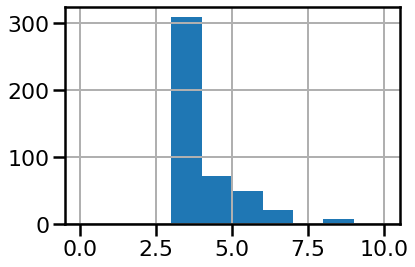

In [571]:
ap1.pIC50.hist(range=(0,10))

<AxesSubplot:>

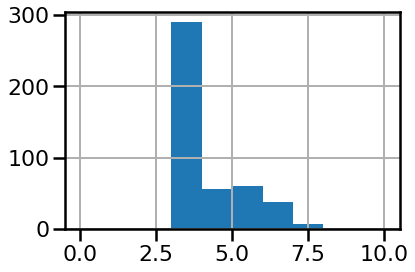

In [572]:
ap2.pIC50.hist(range=(0,10))

In [573]:
print(ap1.shape)

(467, 26)


In [574]:
print(ap2.shape)

(467, 26)


In [575]:
ap1=ap1.drop_duplicates()
ap1.shape

(467, 26)

In [576]:
ap2=ap2.drop_duplicates()
ap2.shape

(467, 26)

In [577]:
ap1.IC50=ap1.IC50.replace('> 39.8',39.8) # censored values
ap2.IC50=ap2.IC50.replace('> 39.8',39.8)
ap1['relation']=np.nan
ap1.loc[ap1.IC50==39.8, 'relation']='>'
ap2['relation']=np.nan
ap2.loc[ap2.IC50==39.8, 'relation']='>'

In [578]:
ap1.loc[ap1.hitc==0, 'relation']='>' # fill non-hits with censored data only in relation and pIC50 column
ap1.loc[ap1.hitc==0, 'pIC50']=-np.log10(39.8/1000000)-1

ap2.loc[ap2.hitc==0, 'relation']='>'
ap2.loc[ap2.hitc==0, 'pIC50']=-np.log10(39.8/1000000)-1

In [579]:
ap1.loc[ap1.pIC50.isna(), 'relation']='>' # fill NA pIC50's with censored data
ap1.loc[ap1.pIC50.isna(), 'pIC50']=-np.log10(39.8/1000000)-1

ap2.loc[ap2.pIC50.isna(), 'relation']='>'
ap2.loc[ap2.pIC50.isna(), 'pIC50']=-np.log10(39.8/1000000)-1

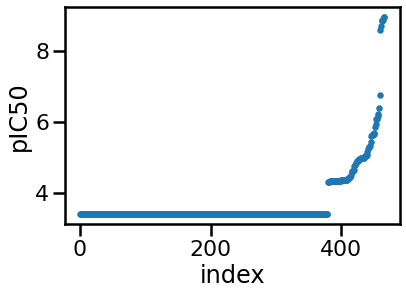

In [580]:
ap1=ap1.sort_values('pIC50')
ap1=ap1.reset_index(drop=True).reset_index()
ap1.plot(x='index', y='pIC50', kind='scatter')
ap1=ap1.drop(columns='index')

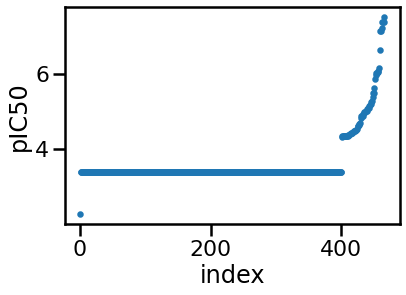

In [581]:
ap2=ap2.sort_values('pIC50')
ap2=ap2.reset_index(drop=True).reset_index()
ap2.plot(x='index', y='pIC50', kind='scatter')
ap2=ap2.drop(columns='index')

In [594]:
ap2[ap2.IC50==ap2.IC50.max()]

,Compound,Alias,SMILES,Lot_#,Lot_Alias,Salt,Solvate,Vendor,PAINS,Bruns_Watson_Demerit_Score,bottom,bottomerror,fitmethod,notes,hill,hillerror,IC50,pIC50,R^2,top,toperror,Target,max_meas,delta,hitc,RMSE,relation
0,1084267,NaN,O=C(CNS(=O)(=O)c1ccccc1)N2CCCC(C2)c3nnc4ccccn34,1,P3459675,None,None,Otava,0,8,41142.473059,NaN,Logistic_FourParameters,Fit succeeded with SciPy,-1.291671,NaN,5360.432579,3.400117,0.766496,15.83956,NaN,PARP2,88.868496,95.057451,1,15.493765,>


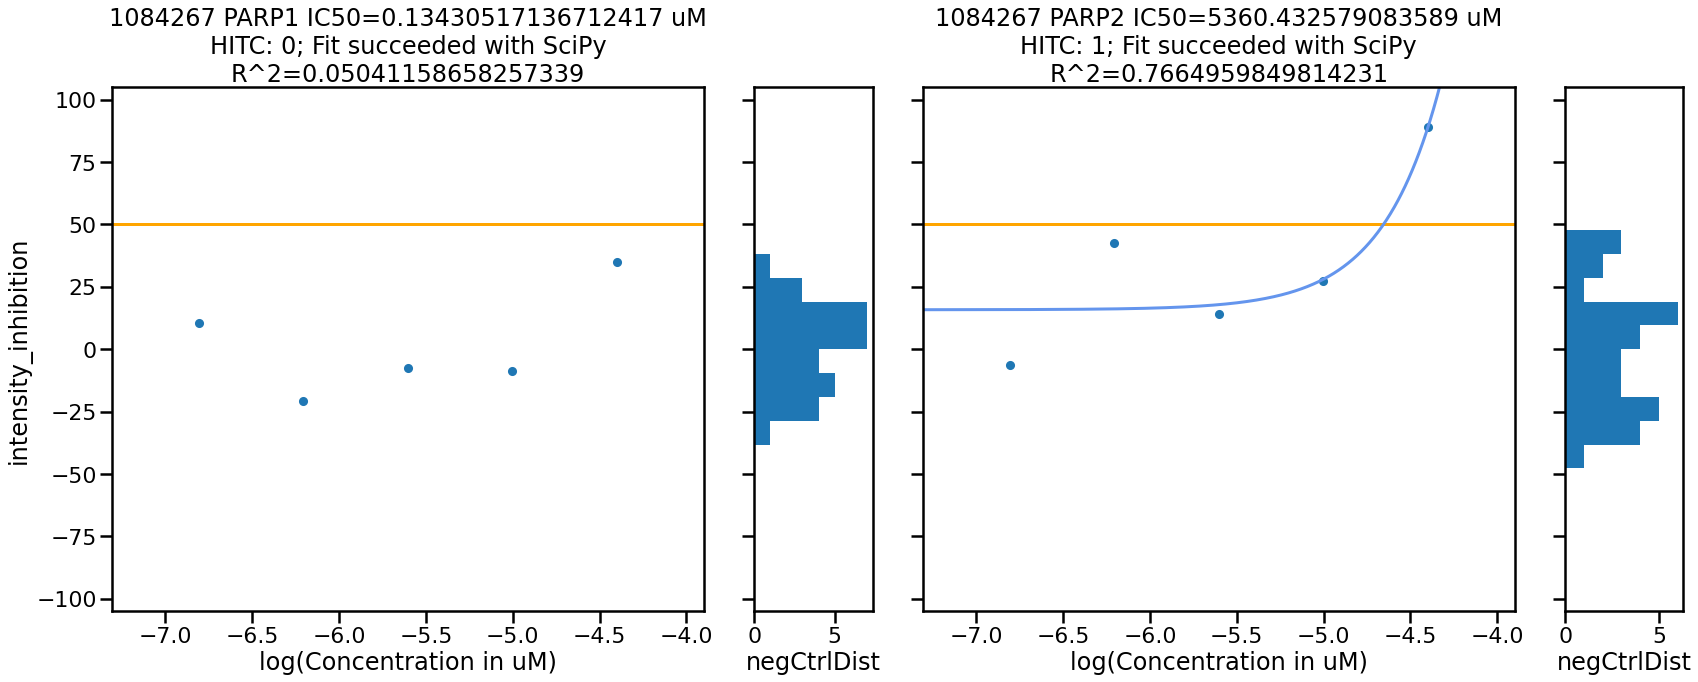

In [584]:
plot_parp_curves(1084267, curve=pd.concat([ap1,ap2]).reset_index(drop=True), raw=pr)

In [585]:
ap2.loc[ap2.Compound==1084267, 'relation']='>' # censored data to replace extreme value
ap2.loc[ap2.Compound==1084267, 'pIC50']=-np.log10(39.8/1000000)-1

In [590]:
ap1[ap1.IC50==ap1.IC50.max()]

,Compound,Alias,SMILES,Lot_#,Lot_Alias,Salt,Solvate,Vendor,PAINS,Bruns_Watson_Demerit_Score,bottom,bottomerror,fitmethod,notes,hill,hillerror,IC50,pIC50,R^2,top,toperror,Target,max_meas,delta,hitc,RMSE,relation
276,1084001,NaN,Cc1sc(N)nc1c2ccc3OCC(=O)Nc3c2,1,P7020390496,None,None,Otava,0,NaN,0.550129,NaN,Logistic_FourParameters,Fit succeeded with SciPy,-28.667084,NaN,2.072248e+06,3.400117,0.0,9.152395,NaN,PARP1,26.25289,30.455965,0,11.148287,>


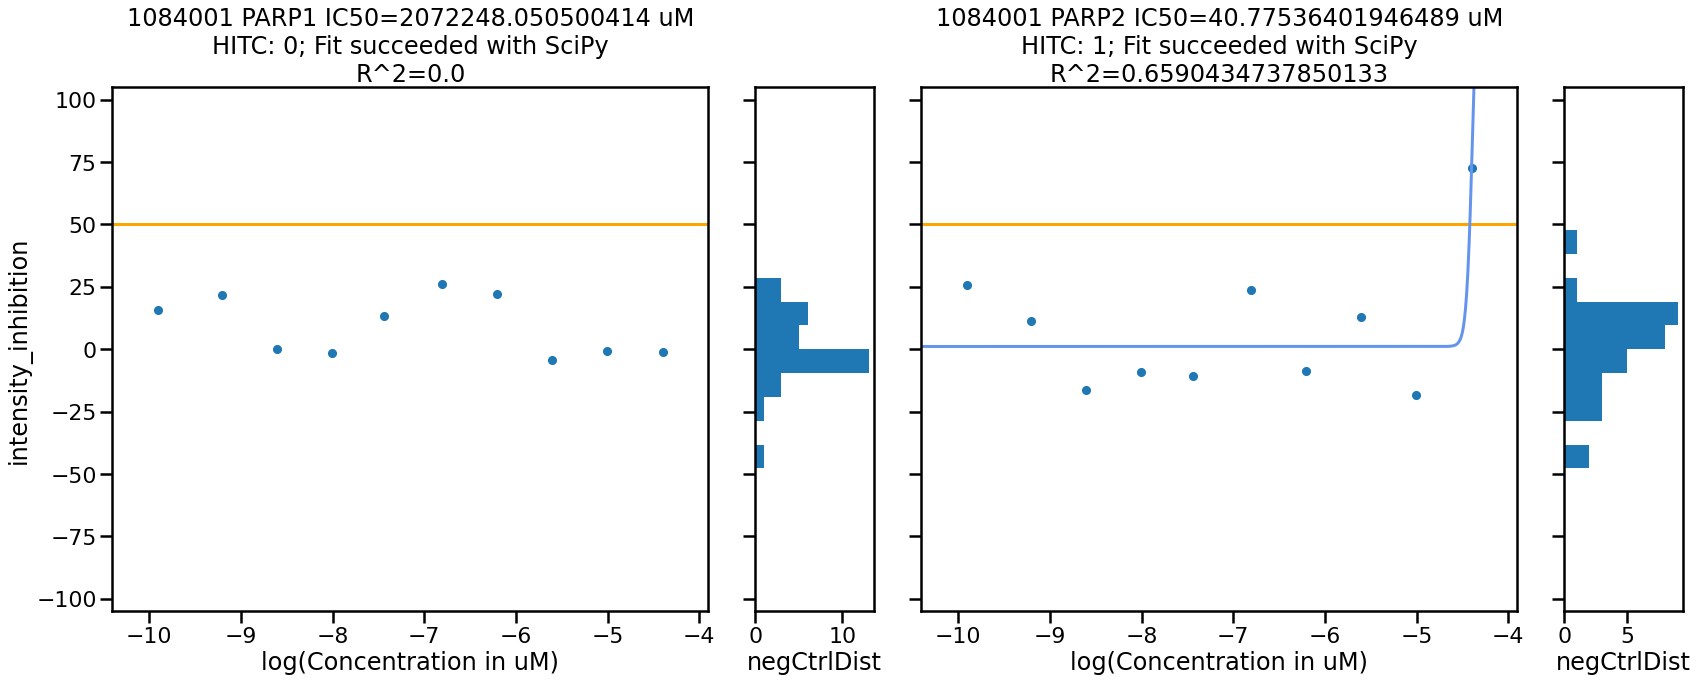

In [586]:
plot_parp_curves(1084001, curve=pd.concat([ap1,ap2]).reset_index(drop=True), raw=pr)

In [591]:
ap1[ap1.IC50==ap1.IC50.min()]

,Compound,Alias,SMILES,Lot_#,Lot_Alias,Salt,Solvate,Vendor,PAINS,Bruns_Watson_Demerit_Score,bottom,bottomerror,fitmethod,notes,hill,hillerror,IC50,pIC50,R^2,top,toperror,Target,max_meas,delta,hitc,RMSE,relation
465,1084345,NaN,CCc1cc2ncc(CN3CCN(CC3)c4ccc(nc4)C(=O)NC)cc2nc1O,2,AZD5305,None,None,NaN,0,16,-20.0,NaN,Logistic_FourParameters,Fit succeeded; bottom fixed at -20,0.7797,0.07508,0.001078,8.967,0.9984,101.3,1.309,PARP1,100.351806,62.006811,1,NaN,NaN
466,1084345,NaN,CCc1cc2ncc(CN3CCN(CC3)c4ccc(nc4)C(=O)NC)cc2nc1O,2,AZD5305,None,None,NaN,0,16,-20.0,NaN,Logistic_FourParameters,Fit succeeded; bottom fixed at -20,0.7797,0.07508,0.001078,8.967,0.9984,101.3,1.309,PARP1,99.950424,53.244240,1,NaN,NaN


In [592]:
ap2[ap2.IC50==ap2.IC50.min()]

,Compound,Alias,SMILES,Lot_#,Lot_Alias,Salt,Solvate,Vendor,PAINS,Bruns_Watson_Demerit_Score,bottom,bottomerror,fitmethod,notes,hill,hillerror,IC50,pIC50,R^2,top,toperror,Target,max_meas,delta,hitc,RMSE,relation
284,193959,NaN,Cn1ncc2c(NCCc3c[nH]c4ccccc34)ncnc12,2,P1737378,None,None,Otava,0,NaN,139925.936314,NaN,Logistic_FourParameters,Fit succeeded with SciPy,0.440249,NaN,5.757799e-09,3.400117,0.505782,-86.114654,NaN,PARP2,-6.660348,94.379648,0,24.398013,>


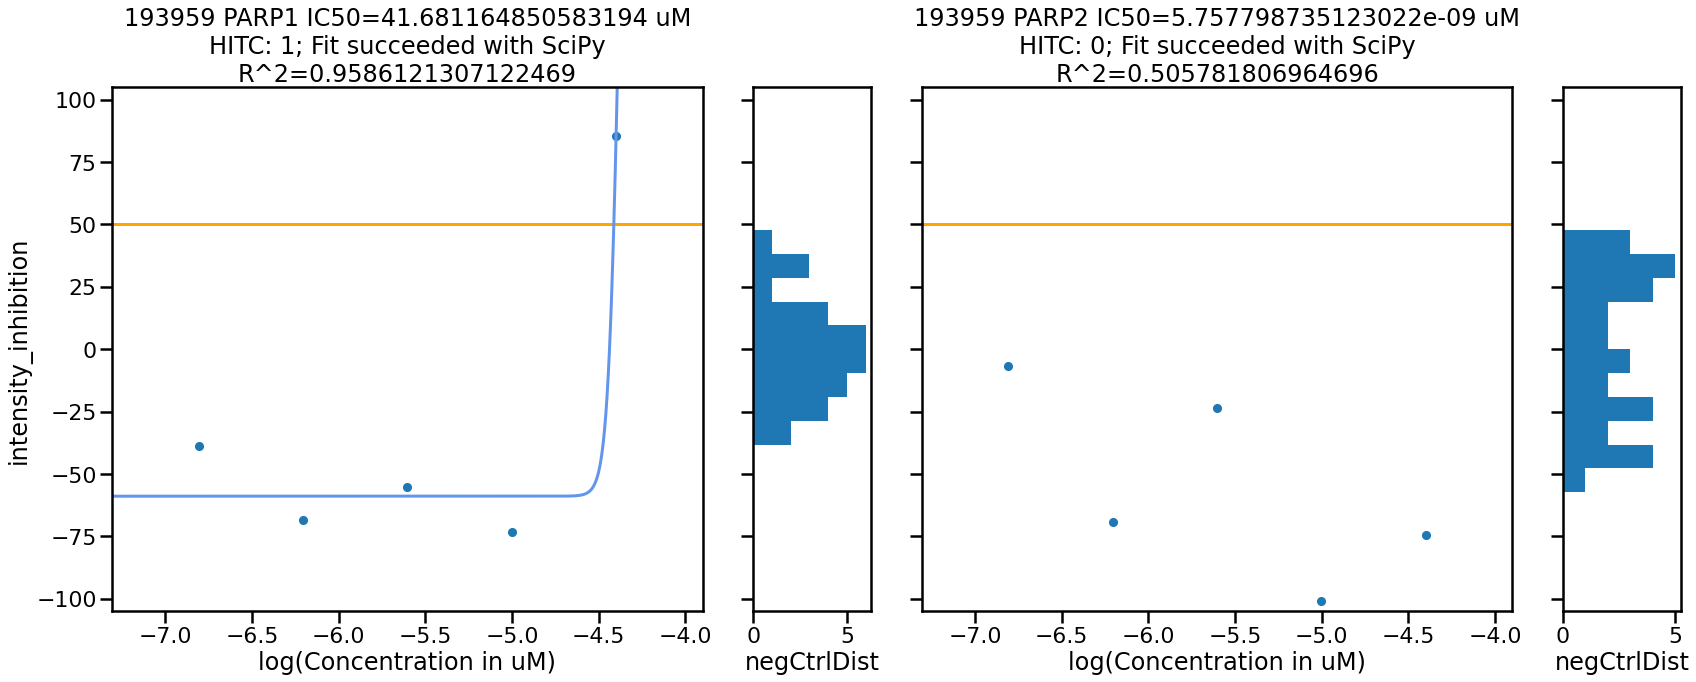

In [595]:
plot_parp_curves(193959, curve=pd.concat([ap1,ap2]).reset_index(drop=True), raw=pr)

In [596]:
ap1.loc[ap1.pIC50.isna()]

,Compound,Alias,SMILES,Lot_#,Lot_Alias,Salt,Solvate,Vendor,PAINS,Bruns_Watson_Demerit_Score,bottom,bottomerror,fitmethod,notes,hill,hillerror,IC50,pIC50,R^2,top,toperror,Target,max_meas,delta,hitc,RMSE,relation


In [597]:
ap2.loc[ap2.pIC50.isna()]

,Compound,Alias,SMILES,Lot_#,Lot_Alias,Salt,Solvate,Vendor,PAINS,Bruns_Watson_Demerit_Score,bottom,bottomerror,fitmethod,notes,hill,hillerror,IC50,pIC50,R^2,top,toperror,Target,max_meas,delta,hitc,RMSE,relation


In [598]:
ap1[ap1.Compound.duplicated(keep=False)].sort_values('Compound')

,Compound,Alias,SMILES,Lot_#,Lot_Alias,Salt,Solvate,Vendor,PAINS,Bruns_Watson_Demerit_Score,bottom,bottomerror,fitmethod,notes,hill,hillerror,IC50,pIC50,R^2,top,toperror,Target,max_meas,delta,hitc,RMSE,relation
455,1084272,NaN,Oc1nnc(CC(=O)Nc2ccc3OCCOc3c2)c4ccccc14,1,P6665730,None,None,Otava,0,20,33.990,0.4617,Logistic_FourParameters,Fit succeeded,3.0170,0.183300,0.816000,6.088,1.0000,98.80,0.3073,PARP1,99.100297,64.670916,1,NaN,NaN
457,1084272,NaN,Oc1nnc(CC(=O)Nc2ccc3OCCOc3c2)c4ccccc14,1,P6665730,None,None,Otava,0,20,-1.848,0.6629,Logistic_FourParameters,Fit succeeded,1.7500,0.036040,0.602500,6.220,1.0000,100.30,0.2048,PARP1,100.036817,93.113941,1,NaN,NaN
449,1084283,NaN,Oc1nnc(CC(=O)Nc2ccc3[nH]ccc3c2)c4ccccc14,1,P6665752,None,None,Otava,0,20,2.382,9.0720,Logistic_FourParameters,Fit succeeded,14.6500,0.000116,2.220000,5.654,0.9844,99.93,9.0720,PARP1,100.972033,107.602695,1,NaN,NaN
450,1084283,NaN,Oc1nnc(CC(=O)Nc2ccc3[nH]ccc3c2)c4ccccc14,1,P6665752,None,None,Otava,0,20,2.320,5.8360,Logistic_FourParameters,Fit succeeded,13.1500,0.000092,2.214000,5.655,0.9932,98.43,5.8360,PARP1,100.234017,103.464788,1,NaN,NaN
441,1084284,NaN,COc1cccc2c1ccn2CCNC(=O)Cc3nnc(O)c4ccccc34,1,P7130594,None,None,Otava,0,28,3.037,15.0100,Logistic_FourParameters,Fit succeeded,1.6210,1.405000,5.854000,5.233,0.9570,100.10,26.9200,PARP1,96.635457,104.605829,1,NaN,NaN
445,1084284,NaN,COc1cccc2c1ccn2CCNC(=O)Cc3nnc(O)c4ccccc34,1,P7130594,None,None,Otava,0,28,-2.457,6.4440,Logistic_FourParameters,Fit succeeded,1.4040,0.448000,3.641000,5.439,0.9954,100.50,9.1500,PARP1,98.011706,96.730792,1,NaN,NaN
451,1084285,NaN,Oc1nnc(CC(=O)Nc2cc(F)c(F)c(F)c2)c3ccccc13,1,P6665756,None,None,Otava,0,30,-7.260,2.8580,Logistic_FourParameters,Fit succeeded,13.3800,0.000104,2.092000,5.680,0.9987,99.43,2.8580,PARP1,99.667247,109.775564,1,NaN,NaN
458,1084285,NaN,Oc1nnc(CC(=O)Nc2cc(F)c(F)c(F)c2)c3ccccc13,1,P6665756,None,None,Otava,0,30,-20.000,NaN,Logistic_FourParameters,Fit succeeded; bottom fixed at -20,1.2440,0.109300,0.413200,6.384,0.9995,99.41,2.2060,PARP1,99.665274,93.477481,1,NaN,NaN
460,1084345,NaN,CCc1cc2ncc(CN3CCN(CC3)c4ccc(nc4)C(=O)NC)cc2nc1O,2,AZD5305,None,None,NaN,0,16,-20.000,NaN,Logistic_FourParameters,Fit succeeded; bottom fixed at -20,6.0230,6.151000,0.002562,8.591,0.9993,98.76,0.9898,PARP1,100.318653,120.847294,1,NaN,NaN
461,1084345,NaN,CCc1cc2ncc(CN3CCN(CC3)c4ccc(nc4)C(=O)NC)cc2nc1O,2,AZD5305,None,None,NaN,0,16,-20.000,NaN,Logistic_FourParameters,Fit succeeded; bottom fixed at -20,1.3090,0.046670,0.002014,8.696,0.9999,100.40,0.5261,PARP1,100.228036,86.713627,1,NaN,NaN


In [599]:
ap2[ap2.Compound.duplicated(keep=False)].sort_values('Compound')

,Compound,Alias,SMILES,Lot_#,Lot_Alias,Salt,Solvate,Vendor,PAINS,Bruns_Watson_Demerit_Score,bottom,bottomerror,fitmethod,notes,hill,hillerror,IC50,pIC50,R^2,top,toperror,Target,max_meas,delta,hitc,RMSE,relation
446,1084272,NaN,Oc1nnc(CC(=O)Nc2ccc3OCCOc3c2)c4ccccc14,1,P6665730,None,None,Otava,0,20,22.710,8.30300,Logistic_FourParameters,Fit succeeded,2.2050,1.30700,5.59400,5.252,0.9766,99.08,12.70000,PARP2,98.291590,83.141117,1,NaN,NaN
449,1084272,NaN,Oc1nnc(CC(=O)Nc2ccc3OCCOc3c2)c4ccccc14,1,P6665730,None,None,Otava,0,20,28.700,5.15800,Logistic_FourParameters,Fit succeeded,2.5610,1.78300,3.36700,5.473,0.9903,98.87,7.15900,PARP2,99.698626,74.930929,1,NaN,NaN
445,1084283,NaN,Oc1nnc(CC(=O)Nc2ccc3[nH]ccc3c2)c4ccccc14,1,P6665752,None,None,Otava,0,20,-11.920,5.69400,Logistic_FourParameters,Fit succeeded,2.4980,0.89680,6.60300,5.180,0.9945,99.34,8.64300,PARP2,98.061460,115.261407,1,NaN,NaN
450,1084283,NaN,Oc1nnc(CC(=O)Nc2ccc3[nH]ccc3c2)c4ccccc14,1,P6665752,None,None,Otava,0,20,16.940,7.85200,Logistic_FourParameters,Fit succeeded,2.1300,1.52800,3.30600,5.481,0.9847,98.17,10.64000,PARP2,99.535936,87.183624,1,NaN,NaN
454,1084284,NaN,COc1cccc2c1ccn2CCNC(=O)Cc3nnc(O)c4ccccc34,1,P7130594,None,None,Otava,0,28,5.459,0.19940,Logistic_FourParameters,Fit succeeded,1.9940,0.01491,0.98680,6.006,1.0000,100.80,0.12160,PARP2,100.654096,92.846243,1,NaN,NaN
456,1084284,NaN,COc1cccc2c1ccn2CCNC(=O)Cc3nnc(O)c4ccccc34,1,P7130594,None,None,Otava,0,28,36.460,0.09991,Logistic_FourParameters,Fit succeeded,2.6310,0.02069,0.92980,6.032,1.0000,100.10,0.06661,PARP2,100.137958,63.098950,1,NaN,NaN
455,1084285,NaN,Oc1nnc(CC(=O)Nc2cc(F)c(F)c(F)c2)c3ccccc13,1,P6665756,None,None,Otava,0,30,26.500,1.93400,Logistic_FourParameters,Fit succeeded,2.8110,0.37990,0.97850,6.009,0.9993,97.75,1.31700,PARP2,99.010869,72.096340,1,NaN,NaN
457,1084285,NaN,Oc1nnc(CC(=O)Nc2cc(F)c(F)c(F)c2)c3ccccc13,1,P6665756,None,None,Otava,0,30,17.020,0.59070,Logistic_FourParameters,Fit succeeded,1.7400,0.04172,0.85600,6.068,1.0000,99.70,0.30240,PARP2,99.359136,78.288236,1,NaN,NaN
460,1084345,NaN,CCc1cc2ncc(CN3CCN(CC3)c4ccc(nc4)C(=O)NC)cc2nc1O,2,AZD5305,None,None,NaN,0,16,-20.000,NaN,Logistic_FourParameters,Fit succeeded; bottom fixed at -20,1.8710,0.69020,0.07425,7.129,0.9467,101.40,6.58000,PARP2,103.302158,163.038995,1,NaN,NaN
461,1084345,NaN,CCc1cc2ncc(CN3CCN(CC3)c4ccc(nc4)C(=O)NC)cc2nc1O,2,AZD5305,None,None,NaN,0,16,-20.000,NaN,Logistic_FourParameters,Fit succeeded; bottom fixed at -20,1.8710,0.69020,0.07425,7.129,0.9467,101.40,6.58000,PARP2,106.471582,122.190061,1,NaN,NaN


In [607]:
ap1['REAL_IC50_uM']=10**(-ap1.pIC50) * 1000000
ap2['REAL_IC50_uM']=10**(-ap1.pIC50) * 1000000

In [608]:
solissues=[
1084102,
1084103,
897986,
1084135,
54897,
1084159,
1084045,
794012,
1084174,
1084177,
51205,
1084059,
1084183,
1084066,
1084188,
1084077,
1062733,
1084086,
1084087,
1084089,
1084096,
1084227,
1084246,
88248,
1084259,
1084263,
1084274,
1084275,
1084286,
1084320,
1084331,
]

In [609]:
ap1['solubility']=[0 if x in solissues else 1 for x in ap1.Compound]
ap2['solubility']=[0 if x in solissues else 1 for x in ap2.Compound]

In [610]:
ap1.to_csv('./PARP12_inhibition_curves/PARP1_otava_pIC50_cur.csv')
ap2.to_csv('./PARP12_inhibition_curves/PARP2_otava_pIC50_cur.csv')

In [603]:
sum(ap1.pIC50>3.41)

87

In [604]:
sum(ap2.pIC50>3.41)

66